# Package Delivery Drone Pathfinding Implementation using A* Algorithm
***
RMIT University Vietnam\
COSC2968|COSC3053 - Foundations of Artificial Intelligence for STEM\
Assignment 2 - OPTION A (PROGRAMMING): Classical AI\
Author: Nguyen An Nhien\
Date: 10/08/2024
***


# 1. Introduction
This document proposes a comprehensive pathfinding algorithm design to find the most optimal flight path for the package delivery drone. Our primary goal is to implement a solution which can effectively guide the drone to pre-defined delivery addresses within a city map of reasonable size. It is assumed the drone will begin from a set starting point and traverse to one or multiple addresses represented as end points. It must be able to effectively avoid encountered obstacles and navigate to all valid input destinations. Any input or logic error must be informed to the user instead of providing an inappropriate solution. The program is written in Python language embedded in a Jupyter Notebook file for simple documentations.

## a. Assumptions
The city will be represented as a grid map. However, it is very difficult to accurately represent an actual city map inside a simple grid map using data structures, as there can be many unexpected inconsistencies. A few assumptions must be made to simplify the development process:
- The map is a perfect grid map (all cells are $1x1$ squares).
- The drone can only travel in 8 directions (4 orthogonal and 4 diagonal directions) and perfectly travel between the center point of each cell.
- One cell movement cost in the orthogonal direction is $1$, in the diagonal direction is $\sqrt{2}$.
- As shown in the image, the drone can travel to an adjacent diagonal cell even when there are obstacles in common neighbouring cells.\
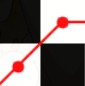

## b. Prerequisites
This implementation of A* algorithm in Python requires some dependencies for visualization purposes. When running this notebook, the following commands will automatically install packages from [PyPI](https://pypi.org/) into the currently running Python environment. [Matplotlib](https://matplotlib.org/) library can visualize the map and movement path directly inside Jupyter's output cell, of which its output can be exported as an image file. Additionally, [NumPy](https://numpy.org/) is used for logic and optimization purposes by utilizing arrays during the visualization process. Both *Matplotlib* and *NumPy* are not required for the pathfinding algorithm and can be excluded by omitting `visualize_astar()` function in `astar()`. Python `math.sqrt()` method is also used and preferred over manually calculating square root for minor optimization and code readability purposes. All dependencies are imported at the start of the program.

In [ ]:
%pip install numpy
%pip install matplotlib

In [2]:
from math import sqrt
import numpy as np
import matplotlib.pyplot as plt

# 2. Foundations
## a. Node Object
A global class is created at the start to represent grid cells on the map that are passed into the algorithm. It is an efficient and flexible way to encapsulate essential data and utilize them throughout the program instead of individually initializing the same variables multiple times. A node object is created only if it is not an obstacle cell or is out of bounds. The node object contains:
- Parent node previously used by the algorithm to find the current node. Consequently, the current node can also be referred to as a child of the parent node.
- Node's horizontal and vertical coordinates on the 2D grid map.
- Path cost from starting position to node ($g$), heuristic distance to goal ($h$) and their sum ($f$). This is based on the formula $f(n) = g(n) + h(n)$ which is used to evaluate and compare the current node with other nodes.
- A special method which makes it possible to check if two nodes have the same coordinates. This will later be used to check if the current node is the end goal.

In [3]:
class Node():

    def __init__(self, parent = None, position = None): # Default constructor assigning values when node is created
        self.parent = parent # Parent nodes of current node
        self.position = position # Node coordinates

        self.g = 0 # Path cost to node
        self.h = 0 # Heuristic to goal: Octile distance heuristic
        self.f = 0 # Evaluation function: f(n) = g(n) + h(n)

    def __eq__(self, other): # Special method for operator == to compare Node objects
        return self.position == other.position

## b. Map visualiztion using Matplotlib
With Jupyter Notebook's format, Matplotlib was the best choice for a simple visualization of a city map. Values can be passed into a function which displays an image in the output cell, integrated directly into this notebook file. While the library is generally used for plotting data graphs, it comes with the necessary utilities to simulate a 2D map for demonstrating the A* pathfinding algorithm. The function takes in 5 parameters: start position, end position (or list of multiple end positions), city map data structure, final path list and explored nodes list. These elements are used to provide a comprehensive visual representation of the A* algorithm final result with negligible decline in runtime.
- Empty spaces are displayed as white. This is the default state when generating a new figure.
- Obstacles are displayed as black squares.
- Starting point is displayed as a green square.
- End point is displayed as a blue square.
- The final path is plotted as red lines, with each small circle representing a node that it traverses through.
- Explored nodes are displayed as small, light blue square.

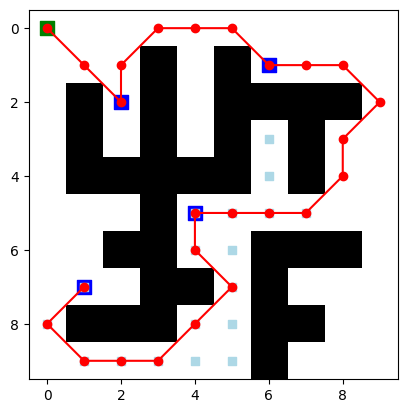


In [4]:
def visualize_astar(start, end, map, path, explored_nodes):
    # Generate figure and axes
    fig, ax = plt.subplots()

    # Visualize map
    # Utilize binary colormap to represent empty space (0) as white, obstacles (1) as black
    ax.imshow(map, cmap = plt.cm.binary)

    # Visualize path
    # Path is converted to NumPy array for compatibility
    path = np.array(path)
    # Path are shown as red lines, with circle markers indicating nodes
    ax.plot(path[:, 1], path[:, 0], marker = "o", color="red")
        
    # Visualize starting point as green square
    ax.scatter(start[1], start[0], s = 100, c = 'g', marker = 's')

    # Visualize end point as blue square
    # Accepts list of multiple end points & loop through each one
    if isinstance(end, list):
        for item in end:
            ax.scatter(item[1], item[0], s = 100, c = 'b', marker = 's')
    # Accepts only one end point
    else:
        ax.scatter(end[1], end[0], s = 100, c = 'b', marker = 's')

    # Visualize explored nodes
    # List of explored nodes is converted to NumPy array for compatibility
    explored_nodes = np.array(explored_nodes)
    # Explored nodes are shown as small light blue squares
    ax.scatter(explored_nodes[:, 1], explored_nodes[:, 0], s = 40, c = 'lightblue', marker = 's')

    # Displays figure
    plt.show()

## c. Heuristic Function
With the established Node object, we can easily devise a function to weigh each node's value against each other by directly calling the coordinates value of the object. As previously stated, the value of a node can be found by applying the evaluation function:
$$\boxed {f(n) = g(n) + h(n)}$$
The algorithm can find $g(n)$ and $h(n)$ using data provided by the current node's parent. $g(n)$ is the total movement cost from the starting point for the algorithm to arrive at the current node. This is simply calculated by finding the sum of movement cost between each node: adding $1$ for one orthogonal movement and adding $\sqrt{2}$ for one diagonal movement. $h(n)$ is called a heuristic function and is a pre-defined equation that estimates a minimum cost from any node to the goal. For a 2D grid map, there are numerous available formulas that can be used as the heuristic function, each of which apply to different pathfinding implementation. Considering the limited scope of work, several notable options stand out:
- **Euclidean distance**: calculates the length of a straight line between two given points regardless of map representation and is represented by the formula $d = \sqrt{\Delta x^2 + \Delta y^2}$
- **Manhattan distance**: also known as taxicab geometry, is the sum of absolute difference between coordinates of two points and is represented by the formula $d = |\Delta x| + |\Delta y|$
- **Diagonal distance**: estimates movement cost to a goal by calculating straight-line distance between nodes in with consideration to either orthogonal or diagonal direction [1]. There are two variations of diagonal distance:
    - Chebyshev distance: also known as chessboard distance, gives all eight directions the same movement cost just like how a king chess piece would move.
    - Octile distance: gives orthogonal movement cost $1$ and diagonal movement cost $sqrt{2}$. 
    
With the given assumptions on movement cost and perfect grid map at the start, **Octile distance** was chosen for the heuristic function in this implementation. Its formula is derived from diagonal distance formula [1]:
$$\boxed {h(n) = D \times (|\Delta x| + |\Delta y|) + (D_2 - 2 \times D) \times min(|\Delta x|, |\Delta y|)}$$
- $\Delta x \text {: difference in x-coordinates}$
- $\Delta y \text {: difference in y-coordinates}$
- $D \text {: cost of orthogonal movement}$
- $D_2 \text {: cost of diagonal movement}$

$D$ and $D_2$ values can vary depending on the purpose of the algorithm. For this implementation, $D = 1$ and $D_2 = 1$ would represent Chebyshev distance heuristic. Consequently, octile distance would have $D = 1$ and $D_2 = \sqrt{2}$.

In [5]:
def heuristic(node, end):
    delta_x = abs(node.position[1] - end.position[1]) # Absolute difference in x-coordinate
    delta_y = abs(node.position[0] - end.position[0]) # Absolute difference in y-coordinate
    D = 1 # Cost of orthogonal movement
    D2 = sqrt(2) # Cost of diagonal movement

    # Apply octile distance formula and return result
    return D * (delta_x + delta_y) + (D2 - 2 * D) * min(delta_x, delta_y)

### Benefits
- **Accuracy**: Octile distance perfectly matches with our initial assumptions. It is designed for grid-based environments by implementing orthogonal and diagonal direction movement costs. This provides more informed heuristic as it matches with our perfect grid map design and restricted movement to only eight directions. In comparison, octile distance can be considered as a modified version of Manhattan distance as they both share $|\Delta x| + |\Delta y|$, where octile distance adds extra elements that also factor in diagonal movements. Additionally, while both Chebyshev and octile distance are derived from the same formula, Chebyshev distance does not accurately reflect real life geometry as diagonal movements should be more costly compared to orthogonal ones.
- **Versatility**: Octile distance is easily adjustable and extendable based on future needs. Assuming our city maps remain grid-based, other form of heuristics can be combined with octile distance to improve upon and further optimize the existing calculation, while still maintaining the benefits of the original formula. 
- **Efficiency**: Octile distance can avoid making redundant checks and potentially overestimating the most optimal path. By only considering the eight possible movements that the algorithm can make, octile distance can skip over nodes with higher potential movement cost and all of its children. In comparison, Euclidean distance tries to find the best route without regards to the grid environment. While that may lead to a better route in an unrestricted environment, a sub-optimal solution would be given in a grid map instead.

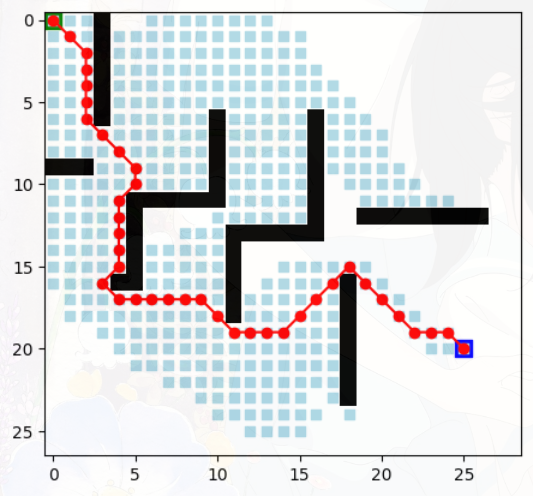
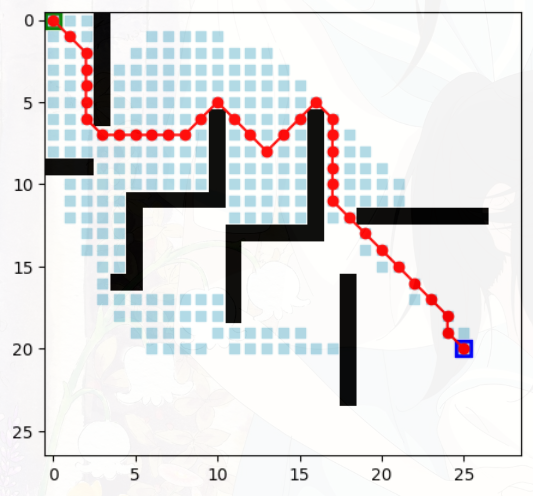

Euclidean distance is used in the left image and octile distance is used in the right image. As shown, Euclidean distance has a greater search range compared to octile distance. Despite this, it still provides a less optimal solution with total path length at roughly 45.87, compared to octile distance's 43.28.

### Limitations
- **Performance & Scalability**: On a larger scale, there may be notable computational overhead caused by the calculation of $\sqrt{2}$ due to its complexity. This can hinder the algorithm in larger maps with more complex pathing required to reach the most optimal solution.
- **Overestimation**: While this may seems contradictory to the previously mentioned benefit in efficiency, it is true that octile distance is still not the most optimal solution available. The heuristic calculates the shortest path to the end point with no regards to obstacles. Therefore, it occasionally makes estimations that does not result in the most optimal solution. This can be seen in the image below which the algorithm makes a diagonal turn at the start instead of going straight forward, unnecessarily extending the path length. 

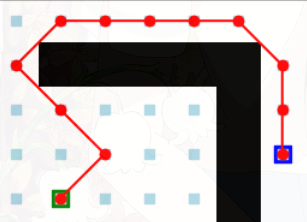

# 3. Algorithm Implementation
## a. Predefined Functions
For readability and optimization purposes, a few functions have been created for independent tasks that may be called extensively.
### Distance Calculation between Two Points
The following function is nearly identical to the `heuristic()` function above, but its parameters are the coordinates of a node instead of the node objects themselves. It is used to calculate the distance between any two given points on the grid map that does not exist as a node object. This is applied in some parts of the implementation where only coordinates of a point is known.

In [6]:
def heuristic_pos(point_1, point_2):
    delta_x = abs(point_1[0] - point_2[0]) # Absolute difference in x-coordinate
    delta_y = abs(point_1[1] - point_2[1]) # Absolute difference in y-coordinate
    D = 1 # Cost of orthogonal movement
    D2 = sqrt(2) # Cost of diagonal movement

    # Apply octile distance formula and return result
    return D * (delta_x + delta_y) + (D2 - 2 * D) * min(delta_x, delta_y)

### Multiple Goals Evaluation
As the drone needs to deliver to multiple addresses, it is not practical to reset its starting point for every delivery. This function is designed to evaluate the heuristic of every remaining end goals. The one with the lowest heuristic value is used in the A* algorithm. The main program will continue looping through the list end goals until all of them have been found.

In [7]:
def sort_end(start, end_list):
    # Iterates through each end point and calculates its heuristic from starting point using heuristic_pos()
    # end_sorted list stores tuples containing coordinates of said end point and the calculated heuristic
    end_sorted = [(end, heuristic_pos(start, end)) for end in end_list]

    # Sorts end_sorted by the second element (heuristic) of each tuple
    end_sorted.sort(key=lambda x: x[1])

    # Creates a new list with coordinates tuples and return that list
    return [end[0] for end in end_sorted]

### Path Construction & Length Calculation 
Once an end goal is found, the algorithm needs to trace back the optimal path it has found. `construct_path()` loops through nodes of said path until it has returned to the start and store the coordinates of all found nodes in a `path` list. The list is reordered to display from starting point to end goal before being returned to the main algorithm. `path_length()` is used to find the total distance traveled on the optimal path for evaluation purposes. This is done by finding the distance between each node using the aforementioned `heuristic_pos()` function and returning their sum. Octile distance can be used in this way because we already assume the orthogonal and diagonal movement cost between two nodes. Since the map is a perfect grid, octile distance between adjacent nodes simply returns their cost. 

In [8]:
def construct_path(current_node):
    path = []
    while current_node is not None: # Iterates through all nodes until path is completed (returns to starting node)
        path.append(current_node.position) # Add current node position to path list
        current_node = current_node.parent # Assigning current node its parent node value
    return path[::-1] # Return reversed path

In [9]:
def path_length(path):
    length = 0
    for item in range(len(path) - 1):
        length += heuristic_pos(path[item], path[item + 1]) # Find distance between two nodes and adding to total path length
    return length

## b. A* Algorithm Function
This is where the main calculations and logic of the program lies, by utilizing the theoretical foundations and predefined functions which have been established. The function accepts 3 parameters: data structure of city map, coordinates of initial start position and coordinates of one or multiple end goals. For simplification purposes, the function can be explained by the following pseudocode:
- List of end points are sorted according to their heuristic from the starting point using `sort_end()`.
- Movement constants and default values are initialized.
- Loop through each end goal from sorted list:
    - Initialize default values for `start_node`, `end_node`, `open_list` and `closed_list`. These values are reset during each end goal iteration.
    - Iterate through the following code while open list is not empty:
        - Find the node with the smallest f value and assign it as `current_node`.
        - Check if the current node is the end goal. If true, calculate the path and adding to total path list, then assign said end goal as the new starting point before returning to start of goal loop. Otherwise, continue.
        - Check for adjacent children nodes to current node. If they are neither not out of bounds nor an obstacle, the node is appended into `children` list.
        - Calculate $f(n)$ of all nodes in `children` and remove the node from open list if its $f$ value is smaller.
    - Error handling: If open list is empty and goal cannot be found, return an error.
- Display visualization and return final path.


In [10]:
def astar(map, start, goal):
    # Checks if is list of multiple goals
    if isinstance(goal, list):
        goal = sort_end(start, goal) # Pass list into function to sort end goals by heuristic
    else:
        goal = [goal] # If only one goal, change from tuple to list for code compatibility
    
    # Initialize movement cost constants
    STEP_COST = 1
    DIAGONAL_COST = sqrt(2)

    # Initialize final path list
    final_path = []

    # Write initial start position into a separate variable
    # This allows start position to be overwritten when looping through multiple end points
    start_position = start

    # Check if is the first starting point
    is_initial_start = True

    for end in goal: # Loops through each end point in list of goals

        # Assign default values for node of starting point
        start_node = Node(None, start_position)
        start_node.g = start_node.h = start_node.f = 0        

        # Assign default values for node of end point
        end_node = Node(None, end)
        end_node.g = end_node.h = end_node.f = 0

        open_list = []          # Nodes to be explored
        closed_list = []        # Nodes explored
        open_list_states = []   # Nodes to be explored coordinates
        closed_list_states = [] # Nodes explored coordinates

        # Add start node and its position to open list
        open_list.append(start_node)
        open_list_states.append(start_node.position)

        # Iterates while open list is not empty
        while len(open_list) > 0:
            # Assign current node & its index the first node in open list
            current_node = open_list[0]
            current_index = 0

             # Find the node with lowest f on open list and assign it as current node
            for index, item in enumerate(open_list):
                if item.f < current_node.f:
                    current_node = item
                    current_index = index

            # Pop current node off open list, add to closed list
            # This marks the node as "has explored"
            open_list.pop(current_index)
            open_list_states.pop(current_index)
            closed_list.append(current_node)
            closed_list_states.append(current_node.position)

            # Check if found the goal
            if current_node == end_node:
                path = construct_path(current_node) # Constructs path from current start point to end point using construct_path() function
                
                # Check if is original starting point and add into path list
                # Added manually to avoid duplicate conflict when extending path
                if is_initial_start == True:
                    path.insert(0, start_node.position)
                    is_initial_start = False
                final_path.extend(path[1:]) # Adds current path to total path
                start_position = end # Assign new start position as current end point
                break # Returns to `for end in goal:`

            # Generate children of current node
            children = []
            for new_position in [(0, -1), (0, 1), (-1, 0), (1, 0), (-1, -1), (-1, 1), (1, -1), (1, 1)]: # Loops through adjacent cells

                # Get adjacent node position
                node_position = (current_node.position[0] + new_position[0], current_node.position[1] + new_position[1])

                # Checks if adjacent node is inside of map
                if node_position[0] > (len(map) - 1) or node_position[0] < 0 or node_position[1] > (len(map[len(map) - 1]) - 1) or node_position[1] < 0:
                    continue
                # Checks if adjacent node is not an obstacle
                if map[node_position[0]][node_position[1]] != 0:
                    continue

                # Create new node
                new_node = Node(current_node, node_position)

                # Append new node as children
                children.append(new_node)

            # Loop through list of children
            for child in children:
                # Check if node already exists
                if child.position in closed_list_states:
                    continue
                if child.position in open_list_states:
                    continue

                # Create f, g and h values
                # Adding appropriate movement cost based on distance between two nodes
                if (heuristic(child, current_node) == 1): 
                    child.g = current_node.g + STEP_COST # Orthogonal movement
                else: 
                    child.g = current_node.g + DIAGONAL_COST # Diagonal movement
                child.h = heuristic(child, end_node)
                child.f = child.g + child.h

                # Update f(n)
                for index, item in enumerate(open_list):
                    # Check for smaller f value
                    if child.position == item.position and child.f < item.f:
                            open_list.pop(index) # Remove the node to replace with child

                # Add the child to the open list
                open_list.append(child)
                open_list_states.append(child.position)
        
        # Error handling: If nothing on open list and current node is not goal
        if not open_list:
            print("No path found to goal:", end)
            return None

    visualize_astar(start, goal, map, final_path, closed_list_states) # Visualize path in output with Matplotlib
    return final_path # Return full path

## c. Test cases & Evaluation
To show the efficiency of A* algorithm in informed search, it is best to analyze an actual map and the algorithm pathfinding logic in practice. All images of test cases will be embedded in this notebook, but they can still be found and run by changing `map_id` to the desired value in the `main()` function below.
### Case 1
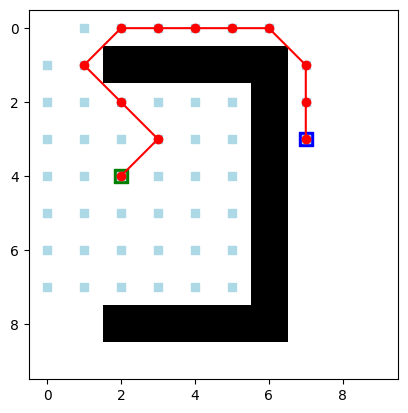

This case was previously used to illustrate the drawbacks in overestimation of octile distance heuristic. The path is mostly optimal except for node `(3, 3)`, where the algorithm makes a diagonal turn, resulting in the total path length of `(4, 2), (3, 3), (2, 2)` to be $2 \sqrt{2}$ instead of $2$. This is due to the current implementation of A* algorithm only perform a simple heuristic check from start to end without regards to potential obstacles in the way. This can be seen from the light blue explored nodes as the algorithm tries to find a direct path towards the end goal before realizing it is not possible and has to find a way around. While it is feasible to develop a separate function alongside the heuristic function to perform such checks, but this may add code complications and computation overhead. These are major drawbacks to consider for very negligible path optimization.
### Case 2
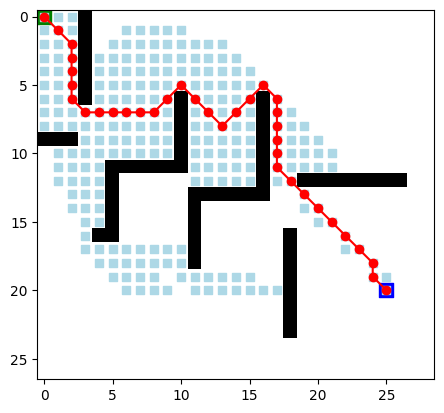

Again, this map was previously used to compare the difference between Euclidean distance and octile distance. While the path is still sub-optimal at `(6, 11), (7, 12), (8, 13), (7, 14), (6, 15)` due to the aforementioned reason in case 1, this is still a far more efficient method compared to using Euclidean distance. In both the bottom and top path, the algorithm always attempt to take the shortest possible path to the end point and only strays off course when presented with an obstacle to find a workaround.
### Case 3

This example illustrates how error handling works in this implementation. Two points are given: `(0, 9)` and `(3, 6)`. While the algorithm can successfully find `(0, 9)`, it does not generate a result and returns an error in output: `No path found to goal: (3, 6)`. This is because the location is inaccessible as there is no valid way for the algorithm to access said end point. This can prevent the drone from performing impossible delivery task due to invalid input or pathfinding.
### Case 4
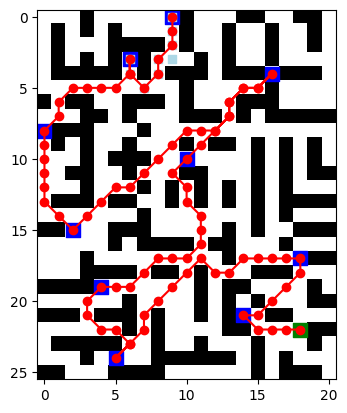\
This case attempts to replicate what an actual city would generally be like and stress test it with 10 different end points. Contrary to previous examples with much more open space, an actual city would have more obstacles, requiring the algorithm to be more precise. All end points are sorted at the start with `sort_end()`, the algorithm just needs to loop through each one and find its way towards them individually. A* is perfectly suitable for obstacle-dense city maps like this due to its nature as an informed search algorithm. Therefore, it can generate such optimal path without having to make many redundant checks.

In [ ]:
def main():
    # Change map ID to desired choice before running program
    map_id = 1

    # Coordinates format: (vertical, horizontal)
    # map: Data structure for city map
    # start: Drone starting position (can be only one point)
    # end: Delivery addresses (can be one or list of multiple points)
    if map_id == 1:
        map =  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 1, 1, 1, 1, 1, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
                [0, 0, 1, 1, 1, 1, 1, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
        start = (4, 2)
        end = (3, 7)

    elif map_id == 2:
        map =  [[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
                [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
        start = (0, 0)
        end = (20, 25)
    
    elif map_id == 3:
        map =  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 1, 0, 1, 0, 0, 0, 0],
                [0, 1, 0, 1, 0, 1, 1, 1, 1, 1],
                [0, 1, 0, 1, 0, 1, 0, 1, 0, 0],
                [0, 1, 1, 1, 1, 1, 0, 1, 0, 1],
                [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]]
        start = (2, 2)
        end = [(0, 9), (3, 6)] 

    elif map_id == 4:
        map =  [[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0],
                [0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0],
                [0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0],
                [0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0],
                [0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0],
                [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
                [1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0],
                [0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1],
                [0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                [0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0],
                [0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0],
                [0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1],
                [0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0],
                [0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1],
                [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0],
                [1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1],
                [0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0],
                [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1],
                [0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0],
                [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0],
                [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1],
                [1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1],
                [0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0],
                [0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0],
                [1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0]]
        start = (22, 18)
        end = [(0, 9), (3, 6), (17, 18), (15, 2), (24, 5), (21, 14), (4, 16), (8, 0), (10, 10), (19, 4)]
    # Error handling: Map ID does not exist
    else:
        print('Invalid map ID.')
        print('\n')
               
    path = astar(map, start, end)

    # Only prints path if it can be calculated
    if path != None:
        print('Path:', path)
        print('Path length:', path_length(path))
        print('\n')

if __name__ == '__main__':
    main()

### References
[1] “Heuristics,” Stanford.edu, 2021. https://theory.stanford.edu/~amitp/GameProgramming/Heuristics.html#diagonal-distance (accessed Aug. 07, 2024).

‌